In [121]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [155]:
sys.path.append('../')
from model import YModel, OptLoss
from utils import generate_data
y_sampler = YModel()
mu_range = (-10, 10)
n_samples = 500
x, conditions = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)

print(x.shape, conditions.shape)

torch.Size([500, 1]) torch.Size([500, 3])


## Define model

In [156]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model = build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='rk4', # rk4
                            hidden_dims=(128, 128),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model.parameters()  if p.requires_grad)

78068

In [160]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 1024
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

In [161]:
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-3)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

B = 5000
for epoch in tqdm(range(1000)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model, data=x_batch, condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

iter 234: loss = 2.072 0.001


KeyboardInterrupt: 

## Evalutation

In [260]:
device = torch.device('cuda:3')
class HybridMC(nn.Module):
    def __init__(self, model, dim_q, L, epsilon, q=None, covariance='unit', t=1.):
        super(HybridMC, self).__init__()
        self._model = model
        self._epsilon = epsilon
        if q is not None:
            self._q = torch.tensor(q).float()
        else:
            self._q = torch.zeros(dim_q, requires_grad=True)
        self._p = torch.zeros(dim_q)
        self._L = L
        self._t = t
        if covariance == 'unit':
            self._mean_p = torch.zeros(dim_q)
            self._cov_p = torch.eye(dim_q)
        
    def calc_grad_q(self):
        q = self._q.clone().detach()
        q.requires_grad = True
        loss = self._model(q) / self._t
        loss.backward()
        return q.grad
        
    def step(self, t=1.):
        self._t = t
        self._p = dist.MultivariateNormal(self._mean_p, covariance_matrix=self._cov_p).sample()
        q_old = self._q.clone().detach()
        p_old = self._p.clone().detach()
        # leap frogs steps
        for i in range(self._L):
            self._p = self._p - (self._epsilon / 2) * self.calc_grad_q()
            self._q = self._q + self._epsilon * self._p
            self._p = self._p - (self._epsilon / 2) * self.calc_grad_q()
            
        # metropolis acceptance step
        with torch.no_grad():
            H_end = (self._model(self._q) / self._t + self._p.pow(2).sum()).item()
            H_start = (self._model(q_old) / self._t + p_old.pow(2).sum()).item()
        
        acc_prob = min(1, np.exp(H_start - H_end))
        if not np.random.binomial(1, acc_prob):
            self._q = q_old.clone().detach()
        return self._q
    
class IntermediateModel(nn.Module):
    def __init__(self, model, partial_condition, dim_in, device):
        super(IntermediateModel, self).__init__()
        self._model = model
        self._dim_in = dim_in
        self._partial_condition = partial_condition
        self.device = device
    
    def forward(self, condition: torch.Tensor):
        conditions = torch.cat([
            condition.repeat(len(self._partial_condition), 1).float().to(self.device), 
            self._partial_condition
        ], dim=1)
        
        samples = self._model(torch.randn(len(conditions), self._dim_in).to(self.device), condition=conditions)
        loss = OptLoss.SigmoidLoss(samples, 5, 10).mean()
        return loss

In [272]:
model = model.to(device);
model.eval();
sample_fn, density_fn = get_transforms(model)

In [ ]:
sample_fn, density_fn = get_transforms(model)
int_model = IntermediateModel(sample_fn, partial_condition=conditions[:, [2]], dim_in=1, device=device).to(device)

hmc_prototype = HybridMC(int_model, dim_q=2, L=5, epsilon=0.05).to(device)
from tqdm import tqdm
q_hist = []

for i in tqdm(range(5000)):
    q_hist.append(hmc_prototype.step( t=0.01 ))
    print(q_hist[-1])

In [ ]:
sample_fn, density_fn = get_transforms(model)
int_model = IntermediateModel(sample_fn, partial_condition=conditions[:, [2]], dim_in=1, device=device).to(device)

hmc_prototype = HybridMC(int_model, dim_q=2, q=[15., 15.], L=5, epsilon=0.05).to(device)
from tqdm import tqdm
q_hist_far = []

for i in tqdm(range(5000)):
    q_hist_far.append(hmc_prototype.step( t=0.01 ))
    print(q_hist_far[-1])

In [268]:
mu_range_test = (-30, 30)
batch_size = 100
mu_samples = 5000
model.cpu();

mu = dist.Uniform(*mu_range_test).sample([mu_samples, 2]) # .to(device)
mu.requires_grad=True
mu_r = mu.repeat(1, batch_size).view(-1, 2)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu) * batch_size , 1])) # .to(device)

samples = sample_fn(torch.randn(mu_samples * batch_size, 1).float(), torch.cat([mu_r, x_r],dim=1))
rs = OptLoss.SigmoidLoss(samples, 5, 10).reshape(-1, batch_size).mean(dim=1)

## Two samples

### 1. Starts in center

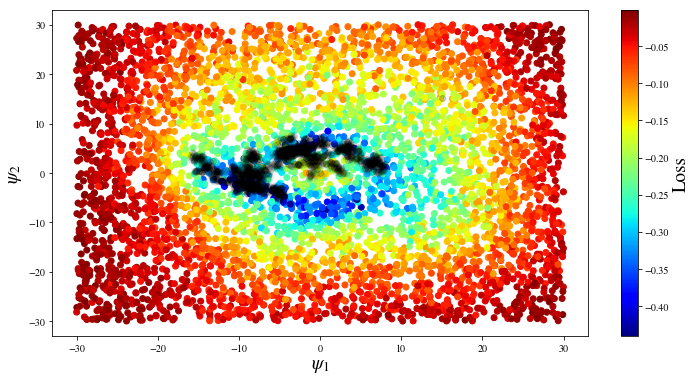

In [286]:
plt.figure(figsize=(12, 6))

plt.scatter(mu[:, 0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

plt.scatter(*torch.stack(q_hist).detach().cpu().numpy().T, c='k', alpha=0.04)

### 2. Starts outside

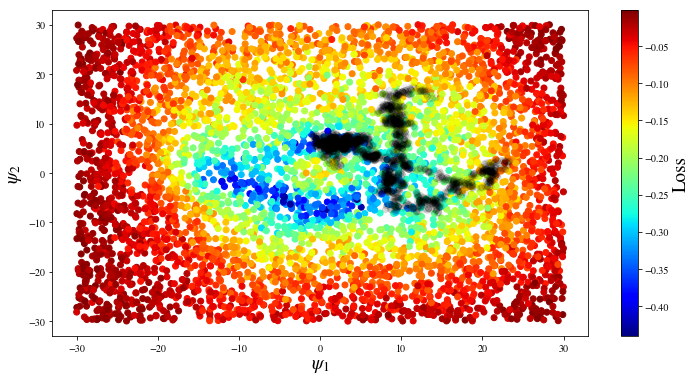

In [287]:
plt.figure(figsize=(12, 6))

plt.scatter(mu[:, 0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

plt.scatter(*torch.stack(q_hist_far).detach().cpu().numpy().T, c='k', alpha=0.04)